In [1]:
import opendssdirect as dss
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
dss.Text.Command('Redirect ./DSS_Data/Iowa240/Master.dss')

In [3]:
df_line = dss.utils.lines_to_dataframe() # dss.line -> line.df
line_graph_data = df_line[['Bus1','Bus2','Length']]
line_graph_data[['Bus1','Bus2']] = line_graph_data[['Bus1','Bus2']].replace('\..*', '', regex=True) # df: Name bus1 bus2 length
# dss.Circuit.SetActiveElement("Line.l_2001_2002")
# dss.CktElement.Open(0,0)

C:\Users\gemin\AppData\Local\Temp\ipykernel_23452\1746257119.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  line_graph_data[['Bus1','Bus2']] = line_graph_data[['Bus1','Bus2']].replace('\..*', '', regex=True) # df: Name bus1 bus2 length


In [4]:
def create_graph(phase=0): 
    if phase not in (0,1,2,3):
        raise ValueError('phase must be 0,1,2,or 3')
    
    G = nx.Graph()
    line_data_temp = df_line[['Bus1', 'Bus2']].to_dict(orient="index") # 提取DF中线路两端信息
    for name in line_data_temp:
        line = line_data_temp[name]
        if phase != 0:
            if f".{phase}" in line["Bus1"] and f".{phase}" in line["Bus2"]: # 仅对指定相的线路
                G.add_edge(line["Bus1"].split(".")[0], line["Bus2"].split(".")[0],Name=f"{name}") # 在空图里添加边
            pos = {}
            # df_busXY = pd.DataFrame(None,columns=['BusName','Coordinate_X','Coordinate_Y'])
            for name in dss.Circuit.AllBusNames():
                dss.Circuit.SetActiveBus(f"{name}") # Set ActiveBus
                if phase in dss.Bus.Nodes(): # 仅针对某个相
                    # df_busXY = df_busXY._append(pd.DataFrame([[f"{name}",dss.Bus.X(),dss.Bus.Y()]],columns=['BusName','Coordinate_X','Coordinate_Y'])) # Coordinate_XY -> df
                     # df_busXY  = df_busXY .set_index('BusName') # Set index = busname
                    pos[dss.Bus.Name()] = (dss.Bus.X(),dss.Bus.Y())
                
        else:
            G.add_edge(line["Bus1"].split(".")[0], line["Bus2"].split(".")[0],Name=f"{name}")            
            pos = {}
            # df_busXY = pd.DataFrame(None,columns=['BusName','Coordinate_X','Coordinate_Y'])
            for name in dss.Circuit.AllBusNames():
                dss.Circuit.SetActiveBus(f"{name}") # Set ActiveBus
                # df_busXY = df_busXY._append(pd.DataFrame([[f"{name}",dss.Bus.X(),dss.Bus.Y()]],columns=['BusName','Coordinate_X','Coordinate_Y'])) # Coordinate_XY -> df
                # df_busXY  = df_busXY .set_index('BusName') # Set index = busname
                pos[dss.Bus.Name()] = (dss.Bus.X(),dss.Bus.Y())
        
    return G,pos 
    

l_2001_2002
False
False
False
True
True
True
l_2017_2018
False
False
False
True
True
True


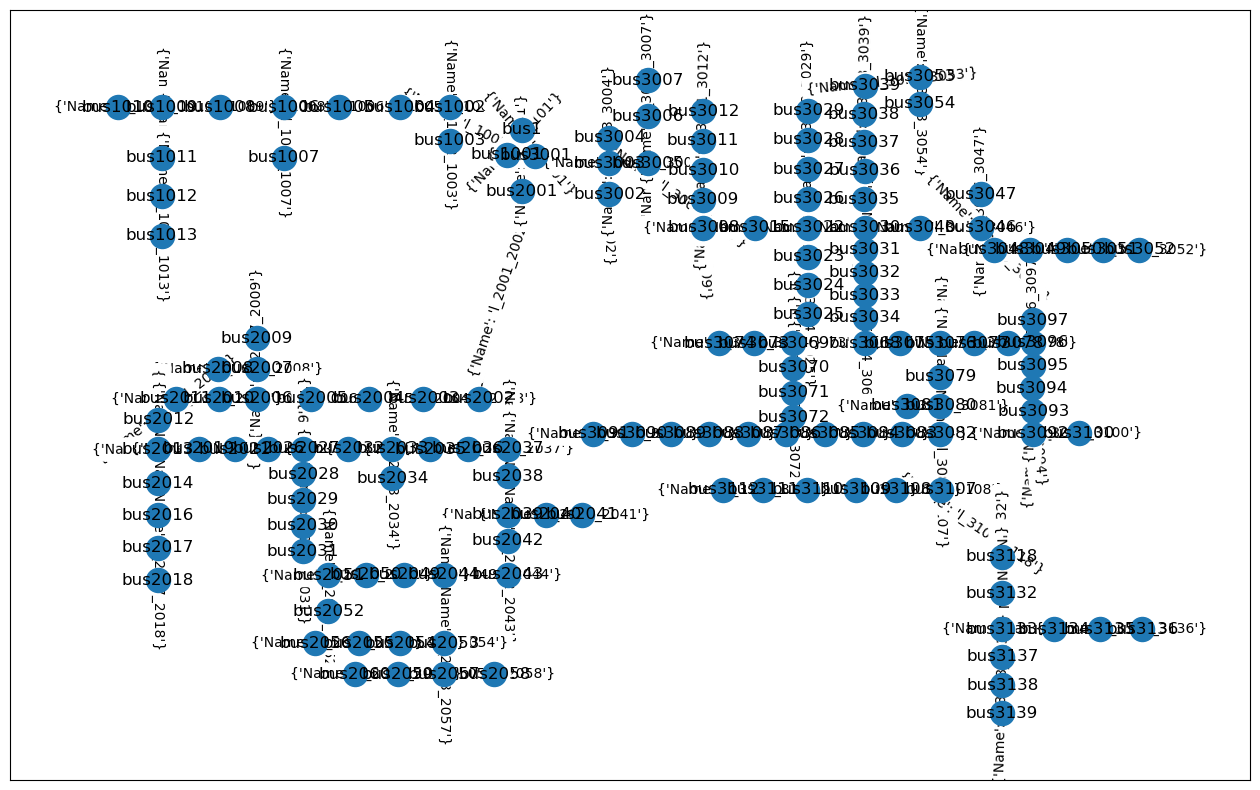

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(16, 10))

ax = axs
G, pos= create_graph(phase=1)



P = G.copy()
P.remove_edges_from([("bus2001","bus2002"),("bus2017","bus2018")]) # 一个去掉了边的子图
diff = nx.difference(G,P) # 比较

bb=nx.to_pandas_edgelist(diff) # 直接把去掉的边转换为DF
res = line_graph_data.loc[(line_graph_data['Bus1'].isin(bb['source']))&(line_graph_data['Bus2'].isin(bb['target'])) ] #返回去掉的边的DF
# 已知边，在opendss中open这些边
for name in res.index:
    print(name)
    dss.Circuit.SetActiveElement("Line."+name)
    print(dss.CktElement.IsOpen(0,1))
    print(dss.CktElement.IsOpen(1,1))
    print(dss.CktElement.IsOpen(2,1))
    dss.CktElement.Open(0,1)
    print(dss.CktElement.IsOpen(0,1))
    print(dss.CktElement.IsOpen(1,1))
    print(dss.CktElement.IsOpen(2,1))



nx.draw_networkx_nodes(G, pos, ax=ax)
nx.draw_networkx_edge_labels(G, pos, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax)
nx.draw_networkx_edges(G, pos, ax=ax)
edges = G.edges(data=True)  # 获取所有边
labels = [d['Name'] for u, v, d in G.edges(data=True) if u == 'bus1001' and v == 'bus1002'] # 已知去掉的(u,v)->断开的线路名称


{'bus3108': Text(18.97, 5.54, 'bus3108'),
 'bus3092': Text(22.05, 6.79, 'bus3092'),
 'bus3082': Text(19.97, 6.79, 'bus3082'),
 'bus3109': Text(18.07, 5.54, 'bus3109'),
 'bus3080': Text(19.97, 7.42, 'bus3080'),
 'bus3132': Text(21.35, 3.22, 'bus3132'),
 'bus3083': Text(19.1, 6.79, 'bus3083'),
 'bus3118': Text(21.36, 4.03, 'bus3118'),
 'bus3107': Text(19.98, 5.54, 'bus3107')}

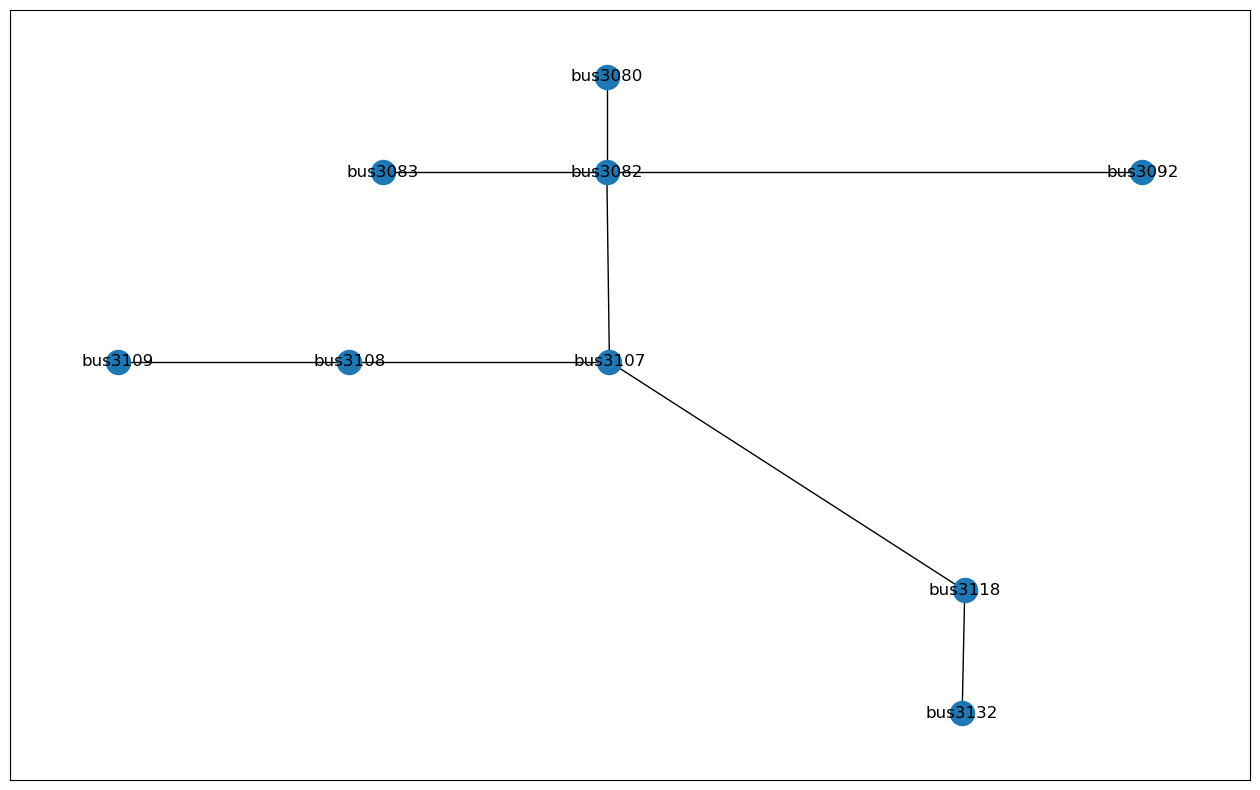

In [6]:
fig2, axs2 = plt.subplots(1, 1, figsize=(16, 10))
ax = axs2
PP=nx.ego_graph(G,"bus3107",radius=2)
nx.draw_networkx_nodes(PP,pos)
nx.draw_networkx_edges(PP, pos)
nx.draw_networkx_labels(PP, pos)

In [7]:
q = [1/G.number_of_nodes()]*240
print(random.choices(list(G.nodes()), weights=q, k=5))

ValueError: The number of weights does not match the population

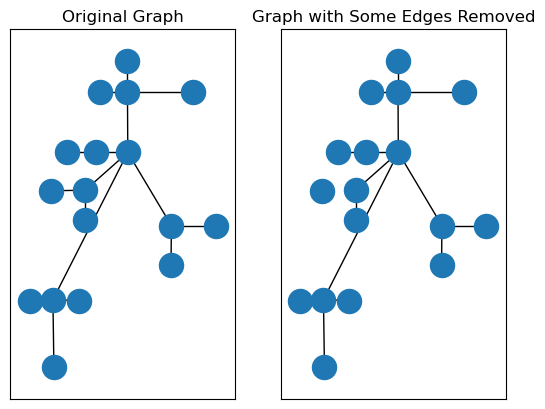

In [ ]:

# 定义要去掉的边的比例
p = 1/PP.number_of_edges()
plt.subplot(121)
nx.draw_networkx_nodes(PP,pos)
nx.draw_networkx_edges(PP, pos)
# nx.draw_networkx_labels(PP, pos)
plt.title('Original Graph')
# 随机去掉一些边
PPP = PP.copy()
# 随机去掉一些边
edges_to_remove = []
for edge in PPP.edges():
    if random.uniform(0, 1) < p:
        edges_to_remove.append(edge)
PPP.remove_edges_from(edges_to_remove)

# 绘制原始图和去掉一些边后的图


plt.subplot(122)
nx.draw_networkx_nodes(PPP,pos)
nx.draw_networkx_edges(PPP, pos)
# nx.draw_networkx_labels(PPP, pos)
plt.title('Graph with Some Edges Removed')
plt.show()